# Short tutorial: context-specific GRN inference from 10x multiome dataset
This is a [Dictys](https://github.com/pinellolab/dictys) tutorial to reconstruct and analyze context-specific GRNs from a [10x multiome dataset on PBMC](https://www.10xgenomics.com/resources/datasets/pbmc-from-a-healthy-donor-granulocytes-removed-through-cell-sorting-10-k-1-standard-2-0-0). For a full version with details of individual steps, see tutorial [full-multiome](https://github.com/pinellolab/dictys/tree/master/doc/tutorials/full-multiome). You should run this notebook inside a conda environment with Dictys installed.

By using this notebook, you imply that you have already accepted the terms of use and privacy policy on the [above 10x dataset webpage](https://www.10xgenomics.com/resources/datasets/pbmc-from-a-healthy-donor-granulocytes-removed-through-cell-sorting-10-k-1-standard-2-0-0). The dataset summary webpage is also available [here](https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_web_summary.html).


## 1. Preparation of individual input files in `data` folder
After data processing with CellRanger, you need the following files:
* RNA read count matrix ("Filtered feature barcode matrix MEX (DIR)")
* ATAC reads ("ATAC Position-sorted alignments (BAM)")
* Optionally or from other softwares: cell clustering (inside "Secondary analysis outputs (DIR)")


In [ ]:
#Create input data folder
!mkdir ../data


### expression.tsv.gz
Read count matrix of RNA-profiled cells in compressed tsv format. Downloaded and converted from "Filtered feature barcode matrix MEX (DIR)".

In [ ]:
%%bash
cd ../data
# Download expression data in mtx.gz format
wget -q -o /dev/null https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.tar.gz
tar xf pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.tar.gz
rm pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.tar.gz
# Convert from mtx.gz to tsv.gz format using helper script `expression_mtx.py`.
dictys_helper expression_mtx.py filtered_feature_bc_matrix expression.tsv.gz
rm -Rf filtered_feature_bc_matrix


### bams
This folder contains one bam file for each cell with chromatin accessibility measurement. File name should be cell name. Downloaded and converted from "ATAC Position-sorted alignments (BAM)".
* **This step can take hours or even over a day**
* The default setting will need ~30GB of memory for this dataset. Specify a lower `--buffer_size 1000` or smaller for `dictys_helper split_bam.sh` if you have less memory.


In [ ]:
%%bash
set -eo pipefail
cd ../data
# Download chromatin accessibility reads in bam format
wget -q -o /dev/null -O bams.bam https://s3-us-west-2.amazonaws.com/10x.files/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_atac_possorted_bam.bam
# Split bam file to individual bam files for each cell using helper script `split_bam.sh`
dictys_helper split_bam.sh bams.bam bams --section "CB:Z:" --ref_expression expression.tsv.gz
rm bams.bam


### subsets & subsets.txt
* subsets.txt: Names of cell subsets. For each cell subset, a GRN is reconstructed.
* subsets: Folder containing one subfolder for each cell subset as in `subsets.txt`. Each subfolder contains two files:
    - names_rna.txt: Names of cells that belong to this subset and have transcriptome measurement
    - names_atac.txt: Names of cells that belong to this subset and have chromatin accessibility measurement
    - For joint measurements of RNA and ATAC, these two files should be identical in every folder.
    
Option 1: download the clustering from 10x "Secondary analysis outputs (DIR)":

In [ ]:
%%bash
cd ../data
wget -q -o /dev/null https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_analysis.tar.gz
#Extract cell names for each cluster
tar xf pbmc_granulocyte_sorted_10k_analysis.tar.gz 
mv analysis/clustering/gex/graphclust/clusters.csv clusters.csv
rm -Rf pbmc_granulocyte_sorted_10k_analysis.tar.gz analysis


Option 2: cluster with other softwares (here [scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) below).

Note: If you don't have scanpy installed, the kernel would automatically restart to finish scanpy installation. Please continue by running this cell again for clustering.

Finally, reformat clusters.csv for input:

In [ ]:
%%bash
cd ../data
subsets="$(tail -n +2 clusters.csv | awk -F , '{print $2}' | sort -u)"
echo "$subsets" | awk '{print "Subset"$1}' > subsets.txt
for x in $subsets; do
	mkdir -p "subsets/Subset$x"
	grep ",$x"'$' clusters.csv | awk -F , '{print $1}' > "subsets/Subset$x/names_rna.txt"
	# RNA and ATAC barcodes are the same for joint quantifications
	cp "subsets/Subset$x/names_rna.txt" "subsets/Subset$x/names_atac.txt"
done
rm clusters.csv


### Other files
Motif, reference genome, gene transcriptional start site

In [ ]:
%%bash
cd ../data

# Motifs (file motifs.motif)
# Option 1: from HOCOMOCO (https://hocomoco11.autosome.org/)
wget -q -o /dev/null -O motifs.motif 'https://hocomoco11.autosome.org/final_bundle/hocomoco11/full/HUMAN/mono/HOCOMOCOv11_full_HUMAN_mono_homer_format_0.0001.motif'
# Option 2: from HOMER
# dictys_helper motif_homer.sh > motifs.motif
# Option 3: provide your custom motifs

# Reference genome (folder genome)
# Note: You need the same reference genome version with chromatin accessibility reads
# Option 1: download genome from HOMER
dictys_helper genome_homer.sh hg38 genome
# Option 2: provide your custom genome

# Bed file for TSS (file gene.bed)
# Download gtf file from ensembl
wget -q -o /dev/null -O gene.gtf.gz http://ftp.ensembl.org/pub/release-107/gtf/homo_sapiens/Homo_sapiens.GRCh38.107.gtf.gz
gunzip gene.gtf.gz
# Convert to bed
dictys_helper gene_gtf.sh gene.gtf gene.bed
rm gene.gtf


### Clean up

In [ ]:
!rm -Rf ../data/filtered_feature_bc_matrix


## 2. Network inference configuration
### Generate configurations
Please adjust them for your own machine and dataset

In [ ]:
%%bash
# Generate configuration template
rm -Rf ../makefiles
mkdir ../makefiles
cd ../makefiles
dictys_helper makefile_template.sh common.mk config.mk env_none.mk static.mk

# Update configurations, such as:
# DEVICE: pytorch device, e.g. cpu, cuda:0. If you do not have a GPU, use 'cpu' and expect LONG computing time.
# GENOME_MACS2: effective genome size for macs2. See https://deeptools.readthedocs.io/en/develop/content/feature/effectiveGenomeSize.html
# JOINT: whether dataset is joint profiling of RNA and ATAC.
# Other configurations include quality control thresholds, number of threads in each job, number of hidden confounders, etc.
# They can be obtained in the full-multiome tutorial.
dictys_helper makefile_update.py ../makefiles/config.mk '{"DEVICE": "cuda:0", "GENOME_MACS2": "hs", "JOINT": "1"}'


### Validate input data

In [6]:
!cd .. && dictys_helper makefile_check.py

Joint profile: True
Found 11898 cells with RNA profile
Found 24036 genes with RNA profile
Found 11898 cells with ATAC profile
Found 769 motifs
Found 678 TFs
Found 461 TFs in current dataset
Missing 217 TFs in current dataset: ANDR,AP2A,AP2B,AP2C,AP2D,ARI3A,ARI5B,ATF6A,BARH1,BARH2,BC11A,BHA15,BHE22,BHE23,BHE40,BHE41,BMAL1,BRAC,BSH,COE1,COT1,COT2,CR3L1,CR3L2,ERR1,ERR2,ERR3,EVI1,GCR,HEN1,HMBX1,HME1,HME2,HNF6,HTF4,HXA1,HXA10,HXA11,HXA13,HXA2,HXA5,HXA7,HXA9,HXB1,HXB13,HXB2,HXB3,HXB4,HXB6,HXB7,HXB8,HXC10,HXC11,HXC12,HXC13,HXC6,HXC8,HXC9,HXD10,HXD11,HXD12,HXD13,HXD3,HXD4,HXD8,HXD9,ITF2,KAISO,MCR,MGAP,MLXPL,MYBA,MYBB,NDF1,NDF2,NF2L1,NF2L2,NFAC1,NFAC2,NFAC3,NFAC4,NGN2,NKX21,NKX22,NKX23,NKX25,NKX28,NKX31,NKX32,NKX61,NKX62,ONEC2,ONEC3,OZF,P53,P5F1B,P63,P73,PEBB,PHX2A,PHX2B,PIT1,PKNX1,PLAL1,PO2F1,PO2F2,PO2F3,PO3F1,PO3F2,PO3F3,PO3F4,PO4F1,PO4F2,PO4F3,PO5F1,PO6F1,PO6F2,PRD14,PRGR,RHXF1,RORG,RX,SMCA1,SMCA5,SRBP1,SRBP2,STA5A,STA5B,STF1,SUH,TF2LX,TF65,TF7L1,TF7L2,TFE2,THA,THA11,THB,TWST1,TYY1,TYY2,UBIP

## 3. Network inference
* **This step can take a day or longer**. You are strongly suggested to use a GPU. If it takes over a day, see [FAQ](https://github.com/pinellolab/dictys#faq) to improve speed.
* Please adjust `-j n_jobs` for your machine. The total thread count is n_jobs*n_threads. By default n_threads=4.


In [7]:
!cd ..; dictys_helper network_inference.sh -j 32 -J 1 static 

mkdir -p tmp_static/Subset1/
make: *** No rule to make target `tmp_static/Subset1/net_weight.tsv.gz', needed by `tmp_static/Subset1/net_nweight.tsv.gz'.
make: *** No rule to make target `tmp_static/Subset1/net_meanvar.tsv.gz', needed by `tmp_static/Subset1/net_nweight.tsv.gz'.
make: *** No rule to make target `tmp_static/Subset1/net_covfactor.tsv.gz', needed by `tmp_static/Subset1/net_nweight.tsv.gz'.
cp data/subsets/Subset1/names_rna.txt tmp_static/Subset1/names_rna.txt
mkdir -p tmp_static/Subset10/
make: *** No rule to make target `tmp_static/Subset10/net_weight.tsv.gz', needed by `tmp_static/Subset10/net_nweight.tsv.gz'.
make: *** No rule to make target `tmp_static/Subset10/net_meanvar.tsv.gz', needed by `tmp_static/Subset10/net_nweight.tsv.gz'.
make: *** No rule to make target `tmp_static/Subset10/net_covfactor.tsv.gz', needed by `tmp_static/Subset10/net_nweight.tsv.gz'.
mkdir -p tmp_static/Subset11/
make: *** No rule to make target `tmp_static/Subset11/net_weight.tsv.gz', needed b

python3 -m dictys  preproc qc_reads  tmp_static/Subset13/expression0.tsv.gz tmp_static/Subset13/expression.tsv.gz 50 10 0 200 100 0
python3 -m dictys  preproc qc_reads  tmp_static/Subset14/expression0.tsv.gz tmp_static/Subset14/expression.tsv.gz 50 10 0 200 100 0
python3 -m dictys  preproc selects_atac  tmp_static/Subset13/expression.tsv.gz tmp_static/Subset13/names_atac0.txt tmp_static/Subset13/names_atac.txt
python3 -m dictys  preproc qc_reads  tmp_static/Subset11/expression0.tsv.gz tmp_static/Subset11/expression.tsv.gz 50 10 0 200 100 0
python3 -m dictys  chromatin macs2 --nth 4 tmp_static/Subset13/names_atac.txt data/bams tmp_static/Subset13/reads.bam tmp_static/Subset13/reads.bai tmp_static/Subset13/peaks.bed hs
python3 -m dictys  preproc selects_atac  tmp_static/Subset14/expression.tsv.gz tmp_static/Subset14/names_atac0.txt tmp_static/Subset14/names_atac.txt
python3 -m dictys  preproc qc_reads  tmp_static/Subset12/expression0.tsv.gz tmp_static/Subset12/expression.tsv.gz 50 10 0 2

python3 -m dictys  chromatin wellington --nth 4 tmp_static/Subset13/reads.bam tmp_static/Subset13/reads.bai tmp_static/Subset13/peaks.bed tmp_static/Subset13/footprints.bed
[bam_sort_core] merging from 4 files and 4 in-memory blocks...
INFO  @ Fri, 16 Sep 2022 17:17:17: 
# Command line: callpeak -t ./tmp_static/Subset14/reads.bam -n 04 -g hs --nomodel --shift -75 --extsize 150 --keep-dup all --verbose 4 --call-summits -q 0.05
# ARGUMENTS LIST:
# name = 04
# format = AUTO
# ChIP-seq file = ['./tmp_static/Subset14/reads.bam']
# control file = None
# effective genome size = 2.70e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 10000 bps
# Broad region calling is off
# Paired-End mode is off
# Searching f

python3 -m dictys  chromatin wellington --nth 4 tmp_static/Subset9/reads.bam tmp_static/Subset9/reads.bai tmp_static/Subset9/peaks.bed tmp_static/Subset9/footprints.bed
[bam_sort_core] merging from 16 files and 4 in-memory blocks...
INFO  @ Fri, 16 Sep 2022 17:18:22: 
# Command line: callpeak -t ./tmp_static/Subset12/reads.bam -n 04 -g hs --nomodel --shift -75 --extsize 150 --keep-dup all --verbose 4 --call-summits -q 0.05
# ARGUMENTS LIST:
# name = 04
# format = AUTO
# ChIP-seq file = ['./tmp_static/Subset12/reads.bam']
# control file = None
# effective genome size = 2.70e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 10000 bps
# Broad region calling is off
# Paired-End mode is off
# Searching for 

python3 -m dictys  chromatin wellington --nth 4 tmp_static/Subset10/reads.bam tmp_static/Subset10/reads.bai tmp_static/Subset10/peaks.bed tmp_static/Subset10/footprints.bed
[bam_sort_core] merging from 24 files and 4 in-memory blocks...
INFO  @ Fri, 16 Sep 2022 17:19:34: 
# Command line: callpeak -t ./tmp_static/Subset6/reads.bam -n 04 -g hs --nomodel --shift -75 --extsize 150 --keep-dup all --verbose 4 --call-summits -q 0.05
# ARGUMENTS LIST:
# name = 04
# format = AUTO
# ChIP-seq file = ['./tmp_static/Subset6/reads.bam']
# control file = None
# effective genome size = 2.70e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 10000 bps
# Broad region calling is off
# Paired-End mode is off
# Searching fo

python3 -m dictys  chromatin wellington --nth 4 tmp_static/Subset4/reads.bam tmp_static/Subset4/reads.bai tmp_static/Subset4/peaks.bed tmp_static/Subset4/footprints.bed
[bam_sort_core] merging from 28 files and 4 in-memory blocks...
INFO  @ Fri, 16 Sep 2022 17:20:01: 
# Command line: callpeak -t ./tmp_static/Subset7/reads.bam -n 04 -g hs --nomodel --shift -75 --extsize 150 --keep-dup all --verbose 4 --call-summits -q 0.05
# ARGUMENTS LIST:
# name = 04
# format = AUTO
# ChIP-seq file = ['./tmp_static/Subset7/reads.bam']
# control file = None
# effective genome size = 2.70e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 10000 bps
# Broad region calling is off
# Paired-End mode is off
# Searching for su

python3 -m dictys  chromatin wellington --nth 4 tmp_static/Subset8/reads.bam tmp_static/Subset8/reads.bai tmp_static/Subset8/peaks.bed tmp_static/Subset8/footprints.bed
[bam_sort_core] merging from 40 files and 4 in-memory blocks...
INFO  @ Fri, 16 Sep 2022 17:21:27: 
# Command line: callpeak -t ./tmp_static/Subset3/reads.bam -n 04 -g hs --nomodel --shift -75 --extsize 150 --keep-dup all --verbose 4 --call-summits -q 0.05
# ARGUMENTS LIST:
# name = 04
# format = AUTO
# ChIP-seq file = ['./tmp_static/Subset3/reads.bam']
# control file = None
# effective genome size = 2.70e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 10000 bps
# Broad region calling is off
# Paired-End mode is off
# Searching for su

python3 -m dictys  chromatin wellington --nth 4 tmp_static/Subset1/reads.bam tmp_static/Subset1/reads.bai tmp_static/Subset1/peaks.bed tmp_static/Subset1/footprints.bed
[bam_sort_core] merging from 52 files and 4 in-memory blocks...
INFO  @ Fri, 16 Sep 2022 17:22:30: 
# Command line: callpeak -t ./tmp_static/Subset2/reads.bam -n 04 -g hs --nomodel --shift -75 --extsize 150 --keep-dup all --verbose 4 --call-summits -q 0.05
# ARGUMENTS LIST:
# name = 04
# format = AUTO
# ChIP-seq file = ['./tmp_static/Subset2/reads.bam']
# control file = None
# effective genome size = 2.70e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 10000 bps
# Broad region calling is off
# Paired-End mode is off
# Searching for su

python3 -m dictys  chromatin binding  tmp_static/Subset13/wellington.tsv.gz tmp_static/Subset13/homer.tsv.gz tmp_static/Subset13/binding.tsv.gz
python3 -m dictys  chromatin tssdist  tmp_static/Subset13/expression.tsv.gz tmp_static/Subset13/wellington.tsv.gz data/gene.bed tmp_static/Subset13/tssdist.tsv.gz
python3 -m dictys  chromatin linking  tmp_static/Subset13/binding.tsv.gz tmp_static/Subset13/tssdist.tsv.gz tmp_static/Subset13/linking.tsv.gz
python3 -m dictys  chromatin binlinking  tmp_static/Subset13/linking.tsv.gz tmp_static/Subset13/binlinking.tsv.gz 20
Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

python3 -m dictys  chromatin homer --nth 4 tmp_static/Subset14/footprints.bed data/motifs.motif data/genome tmp_static/Subset14/expression.tsv.gz tmp_static/Subset14/motifs.bed tmp_static/Subset14/wellington.tsv.gz tmp_static/Subset14/homer.tsv.gz

	Position file = 14-reform-split/aaaab
	Genome = ./data/genome
	Output Directory = 15-motifscan

python3 -m dictys  chromatin binding  tmp_static/Subset14/wellington.tsv.gz tmp_static/Subset14/homer.tsv.gz tmp_static/Subset14/binding.tsv.gz
python3 -m dictys  chromatin tssdist  tmp_static/Subset14/expression.tsv.gz tmp_static/Subset14/wellington.tsv.gz data/gene.bed tmp_static/Subset14/tssdist.tsv.gz
python3 -m dictys  chromatin linking  tmp_static/Subset14/binding.tsv.gz tmp_static/Subset14/tssdist.tsv.gz tmp_static/Subset14/linking.tsv.gz
python3 -m dictys  chromatin binlinking  tmp_static/Subset14/linking.tsv.gz tmp_static/Subset14/binlinking.tsv.gz 20
Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

python3 -m dictys  chromatin homer --nth 4 tmp_static/Subset11/footprints.bed data/motifs.motif data/genome tmp_static/Subset11/expression.tsv.gz tmp_static/Subset11/motifs.bed tmp_static/Subset11/wellington.tsv.gz tmp_static/Subset11/homer.tsv.gz

	Position file = 14-reform-split/aaaab
	Genome = ./data/genome
	Output Directory = 15-motifscan

python3 -m dictys  chromatin binding  tmp_static/Subset11/wellington.tsv.gz tmp_static/Subset11/homer.tsv.gz tmp_static/Subset11/binding.tsv.gz
python3 -m dictys  chromatin tssdist  tmp_static/Subset11/expression.tsv.gz tmp_static/Subset11/wellington.tsv.gz data/gene.bed tmp_static/Subset11/tssdist.tsv.gz
python3 -m dictys  chromatin linking  tmp_static/Subset11/binding.tsv.gz tmp_static/Subset11/tssdist.tsv.gz tmp_static/Subset11/linking.tsv.gz
python3 -m dictys  chromatin binlinking  tmp_static/Subset11/linking.tsv.gz tmp_static/Subset11/binlinking.tsv.gz 20
Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

python3 -m dictys  chromatin homer --nth 4 tmp_static/Subset9/footprints.bed data/motifs.motif data/genome tmp_static/Subset9/expression.tsv.gz tmp_static/Subset9/motifs.bed tmp_static/Subset9/wellington.tsv.gz tmp_static/Subset9/homer.tsv.gz

	Position file = 14-reform-split/aaaac
	Genome = ./data/genome
	Output Directory = 15-motifscan/aaaa

Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

python3 -m dictys  chromatin homer --nth 4 tmp_static/Subset5/footprints.bed data/motifs.motif data/genome tmp_static/Subset5/expression.tsv.gz tmp_static/Subset5/motifs.bed tmp_static/Subset5/wellington.tsv.gz tmp_static/Subset5/homer.tsv.gz
python3 -m dictys  chromatin binding  tmp_static/Subset9/wellington.tsv.gz tmp_static/Subset9/homer.tsv.gz tmp_static/Subset9/binding.tsv.gz
python3 -m dictys  chromatin tssdist  tmp_static/Subset9/expression.tsv.gz tmp_static/Subset9/wellington.tsv.gz data/gene.bed tmp_static/Subset9/tssdist.tsv.gz
python3 -m dictys  chromatin linking  tmp_static/Subset9/binding.tsv.gz tmp_static/Subset9/tssdist.tsv.gz tmp_static/Subset9/linking.tsv.gz
python3 -m dictys  chromatin binlinking  tmp_static/Subset9/linking.tsv.gz tmp_static/Subset9/binlinking.tsv.gz 20

	Position file = 14-reform-split/aaaab
	Genome = ./data/genome
	Output Directory = 15-motifscan/aaaab
	Using ac

python3 -m dictys  chromatin binding  tmp_static/Subset5/wellington.tsv.gz tmp_static/Subset5/homer.tsv.gz tmp_static/Subset5/binding.tsv.gz
python3 -m dictys  chromatin tssdist  tmp_static/Subset5/expression.tsv.gz tmp_static/Subset5/wellington.tsv.gz data/gene.bed tmp_static/Subset5/tssdist.tsv.gz
python3 -m dictys  chromatin linking  tmp_static/Subset5/binding.tsv.gz tmp_static/Subset5/tssdist.tsv.gz tmp_static/Subset5/linking.tsv.gz
python3 -m dictys  chromatin binlinking  tmp_static/Subset5/linking.tsv.gz tmp_static/Subset5/binlinking.tsv.gz 20
Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

python3 -m dictys  chromatin homer --nth 4 tmp_static/Subset6/footprints.bed data/motifs.motif data/genome tmp_static/Subset6/expression.tsv.gz tmp_static/Subset6/motifs.bed tmp_static/Subset6/wellington.tsv.gz tmp_static/Subset6/homer.tsv.gz

	Position file = 14-reform-split/aaaac
	Genome = ./data/genome
	Output Directory = 15-motifscan/aaaac
	Using ac

python3 -m dictys  chromatin binding  tmp_static/Subset6/wellington.tsv.gz tmp_static/Subset6/homer.tsv.gz tmp_static/Subset6/binding.tsv.gz
python3 -m dictys  chromatin tssdist  tmp_static/Subset6/expression.tsv.gz tmp_static/Subset6/wellington.tsv.gz data/gene.bed tmp_static/Subset6/tssdist.tsv.gz
python3 -m dictys  chromatin linking  tmp_static/Subset6/binding.tsv.gz tmp_static/Subset6/tssdist.tsv.gz tmp_static/Subset6/linking.tsv.gz
python3 -m dictys  chromatin binlinking  tmp_static/Subset6/linking.tsv.gz tmp_static/Subset6/binlinking.tsv.gz 20
Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

python3 -m dictys  chromatin homer --nth 4 tmp_static/Subset7/footprints.bed data/motifs.motif data/genome tmp_static/Subset7/expression.tsv.gz tmp_static/Subset7/motifs.bed tmp_static/Subset7/wellington.tsv.gz tmp_static/Subset7/homer.tsv.gz
Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

python3 -m dictys  chro

python3 -m dictys  chromatin binding  tmp_static/Subset7/wellington.tsv.gz tmp_static/Subset7/homer.tsv.gz tmp_static/Subset7/binding.tsv.gz
python3 -m dictys  chromatin tssdist  tmp_static/Subset7/expression.tsv.gz tmp_static/Subset7/wellington.tsv.gz data/gene.bed tmp_static/Subset7/tssdist.tsv.gz

	Position file = 14-reform-split/aaaab
	Genome = ./data/genome
	Output Directory = 15-motifscan/aaaab
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ./data/motifs.motif
	Using Custom Genome
	Peak/BED file conversion summary:
		BED/Header formatted lines: 25001
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 25001
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background fragment size set to 18 (

python3 -m dictys  chromatin linking  tmp_static/Subset7/binding.tsv.gz tmp_static/Subset7/tssdist.tsv.gz tmp_static/Subset7/linking.tsv.gz
Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

python3 -m dictys  chromatin homer --nth 4 tmp_static/Subset10/footprints.bed data/motifs.motif data/genome tmp_static/Subset10/expression.tsv.gz tmp_static/Subset10/motifs.bed tmp_static/Subset10/wellington.tsv.gz tmp_static/Subset10/homer.tsv.gz

	Position file = 14-reform-split/aaaab
	Genome = ./data/genome
	Output Directory = 15-motifscan/aaaab
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ./data/motifs.motif
	Using Custom Genome
	Peak/BED file conversion summary:
		BED/Header formatted lines: 25001
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 25001
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with 

python3 -m dictys  chromatin binlinking  tmp_static/Subset7/linking.tsv.gz tmp_static/Subset7/binlinking.tsv.gz 20
python3 -m dictys  chromatin binding  tmp_static/Subset4/wellington.tsv.gz tmp_static/Subset4/homer.tsv.gz tmp_static/Subset4/binding.tsv.gz
python3 -m dictys  chromatin tssdist  tmp_static/Subset4/expression.tsv.gz tmp_static/Subset4/wellington.tsv.gz data/gene.bed tmp_static/Subset4/tssdist.tsv.gz
python3 -m dictys  chromatin binding  tmp_static/Subset12/wellington.tsv.gz tmp_static/Subset12/homer.tsv.gz tmp_static/Subset12/binding.tsv.gz
python3 -m dictys  chromatin tssdist  tmp_static/Subset12/expression.tsv.gz tmp_static/Subset12/wellington.tsv.gz data/gene.bed tmp_static/Subset12/tssdist.tsv.gz
python3 -m dictys  chromatin linking  tmp_static/Subset4/binding.tsv.gz tmp_static/Subset4/tssdist.tsv.gz tmp_static/Subset4/linking.tsv.gz
python3 -m dictys  chromatin linking  tmp_static/Subset12/binding.tsv.gz tmp_static/Subset12/tssdist.tsv.gz tmp_static/Subset12/linking.t

python3 -m dictys  chromatin binding  tmp_static/Subset10/wellington.tsv.gz tmp_static/Subset10/homer.tsv.gz tmp_static/Subset10/binding.tsv.gz
python3 -m dictys  chromatin tssdist  tmp_static/Subset10/expression.tsv.gz tmp_static/Subset10/wellington.tsv.gz data/gene.bed tmp_static/Subset10/tssdist.tsv.gz
python3 -m dictys  chromatin linking  tmp_static/Subset10/binding.tsv.gz tmp_static/Subset10/tssdist.tsv.gz tmp_static/Subset10/linking.tsv.gz
python3 -m dictys  chromatin binlinking  tmp_static/Subset10/linking.tsv.gz tmp_static/Subset10/binlinking.tsv.gz 20
Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

python3 -m dictys  chromatin homer --nth 4 tmp_static/Subset8/footprints.bed data/motifs.motif data/genome tmp_static/Subset8/expression.tsv.gz tmp_static/Subset8/motifs.bed tmp_static/Subset8/wellington.tsv.gz tmp_static/Subset8/homer.tsv.gz

	Position file = 14-reform-split/aaaab
	Genome = ./data/genome
	Output Directory = 15-motifscan/aaaa

python3 -m dictys  chromatin binding  tmp_static/Subset8/wellington.tsv.gz tmp_static/Subset8/homer.tsv.gz tmp_static/Subset8/binding.tsv.gz
python3 -m dictys  chromatin tssdist  tmp_static/Subset8/expression.tsv.gz tmp_static/Subset8/wellington.tsv.gz data/gene.bed tmp_static/Subset8/tssdist.tsv.gz
python3 -m dictys  chromatin linking  tmp_static/Subset8/binding.tsv.gz tmp_static/Subset8/tssdist.tsv.gz tmp_static/Subset8/linking.tsv.gz
python3 -m dictys  chromatin binlinking  tmp_static/Subset8/linking.tsv.gz tmp_static/Subset8/binlinking.tsv.gz 20
Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

python3 -m dictys  chromatin homer --nth 4 tmp_static/Subset1/footprints.bed data/motifs.motif data/genome tmp_static/Subset1/expression.tsv.gz tmp_static/Subset1/motifs.bed tmp_static/Subset1/wellington.tsv.gz tmp_static/Subset1/homer.tsv.gz

	Position file = 14-reform-split/aaaab
	Genome = ./data/genome
	Output Directory = 15-motifscan/aaaab
	Using ac

python3 -m dictys  chromatin binding  tmp_static/Subset1/wellington.tsv.gz tmp_static/Subset1/homer.tsv.gz tmp_static/Subset1/binding.tsv.gz
python3 -m dictys  chromatin tssdist  tmp_static/Subset1/expression.tsv.gz tmp_static/Subset1/wellington.tsv.gz data/gene.bed tmp_static/Subset1/tssdist.tsv.gz
python3 -m dictys  chromatin linking  tmp_static/Subset1/binding.tsv.gz tmp_static/Subset1/tssdist.tsv.gz tmp_static/Subset1/linking.tsv.gz
python3 -m dictys  chromatin binlinking  tmp_static/Subset1/linking.tsv.gz tmp_static/Subset1/binlinking.tsv.gz 20
Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

python3 -m dictys  chromatin homer --nth 4 tmp_static/Subset3/footprints.bed data/motifs.motif data/genome tmp_static/Subset3/expression.tsv.gz tmp_static/Subset3/motifs.bed tmp_static/Subset3/wellington.tsv.gz tmp_static/Subset3/homer.tsv.gz

	Position file = 14-reform-split/aaaad
	Genome = ./data/genome
	Output Directory = 15-motifscan/aaaad
	Using ac

python3 -m dictys  chromatin binding  tmp_static/Subset3/wellington.tsv.gz tmp_static/Subset3/homer.tsv.gz tmp_static/Subset3/binding.tsv.gz
python3 -m dictys  chromatin tssdist  tmp_static/Subset3/expression.tsv.gz tmp_static/Subset3/wellington.tsv.gz data/gene.bed tmp_static/Subset3/tssdist.tsv.gz
python3 -m dictys  chromatin linking  tmp_static/Subset3/binding.tsv.gz tmp_static/Subset3/tssdist.tsv.gz tmp_static/Subset3/linking.tsv.gz
python3 -m dictys  chromatin binlinking  tmp_static/Subset3/linking.tsv.gz tmp_static/Subset3/binlinking.tsv.gz 20
Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

python3 -m dictys  chromatin homer --nth 4 tmp_static/Subset2/footprints.bed data/motifs.motif data/genome tmp_static/Subset2/expression.tsv.gz tmp_static/Subset2/motifs.bed tmp_static/Subset2/wellington.tsv.gz tmp_static/Subset2/homer.tsv.gz

	Position file = 14-reform-split/aaaab
	Genome = ./data/genome
	Output Directory = 15-motifscan/aaaab
	Using ac

python3 -m dictys  chromatin binding  tmp_static/Subset2/wellington.tsv.gz tmp_static/Subset2/homer.tsv.gz tmp_static/Subset2/binding.tsv.gz
python3 -m dictys  chromatin tssdist  tmp_static/Subset2/expression.tsv.gz tmp_static/Subset2/wellington.tsv.gz data/gene.bed tmp_static/Subset2/tssdist.tsv.gz
python3 -m dictys  chromatin linking  tmp_static/Subset2/binding.tsv.gz tmp_static/Subset2/tssdist.tsv.gz tmp_static/Subset2/linking.tsv.gz
python3 -m dictys  chromatin binlinking  tmp_static/Subset2/linking.tsv.gz tmp_static/Subset2/binlinking.tsv.gz 20
make: Target `cpu' not remade because of errors.
python3 -m dictys  network reconstruct --device cuda:0 --nth 4 tmp_static/Subset1/expression.tsv.gz tmp_static/Subset1/binlinking.tsv.gz tmp_static/Subset1/net_weight.tsv.gz tmp_static/Subset1/net_meanvar.tsv.gz tmp_static/Subset1/net_covfactor.tsv.gz tmp_static/Subset1/net_loss.tsv.gz tmp_static/Subset1/net_stats.tsv.gz
python3 -m dictys  network reconstruct --device cuda:0 --nth 4 tmp_stati

python3 -m dictys  network normalize --nth 4 tmp_static/Subset13/net_iweight.tsv.gz tmp_static/Subset13/net_meanvar.tsv.gz tmp_static/Subset13/net_covfactor.tsv.gz tmp_static/Subset13/net_inweight.tsv.gz
python3 -m dictys  network normalize --nth 4 tmp_static/Subset14/net_iweight.tsv.gz tmp_static/Subset14/net_meanvar.tsv.gz tmp_static/Subset14/net_covfactor.tsv.gz tmp_static/Subset14/net_inweight.tsv.gz
python3 -m dictys  network normalize --nth 4 tmp_static/Subset11/net_iweight.tsv.gz tmp_static/Subset11/net_meanvar.tsv.gz tmp_static/Subset11/net_covfactor.tsv.gz tmp_static/Subset11/net_inweight.tsv.gz
python3 -m dictys  network normalize --nth 4 tmp_static/Subset5/net_iweight.tsv.gz tmp_static/Subset5/net_meanvar.tsv.gz tmp_static/Subset5/net_covfactor.tsv.gz tmp_static/Subset5/net_inweight.tsv.gz
python3 -m dictys  network normalize --nth 4 tmp_static/Subset12/net_iweight.tsv.gz tmp_static/Subset12/net_meanvar.tsv.gz tmp_static/Subset12/net_covfactor.tsv.gz tmp_static/Subset12/net_

## 4. Network analysis
Note: network inference depends on many factors, e.g. pseudo-randomness, randomness, and software version. Your figures may vary from those shown here.

### Regulation marker discovery based on target count & specificity between cell subsets
First we perform global analyses with all GRNs. We can use the reconstructed context specific GRNs to find *regulation marker genes* based on their regulatory activity. 


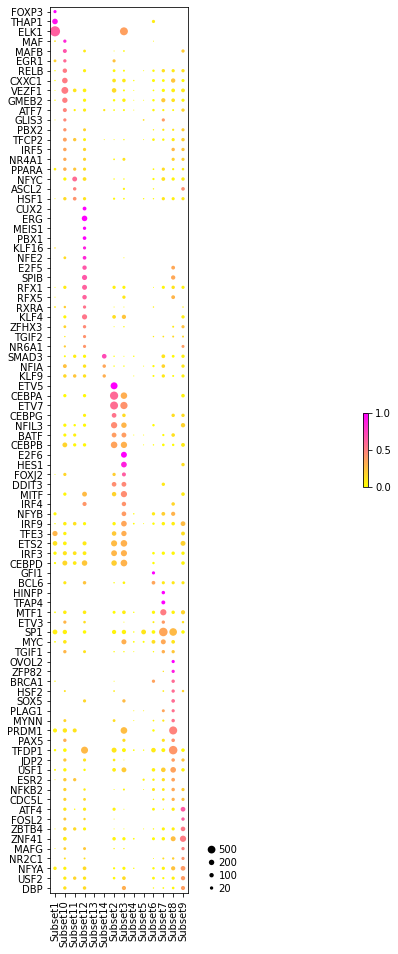

In [31]:
from dictys.plot.static import compute_spec
from dictys.plot import dotplot
from dictys.net import network
import matplotlib.pyplot as plt

#Load networks
d0=network.from_file('../output/static.h5')

#Regulation markers based on TF regulatory activity (by target count) and its specificity
#Color map of specificity
cmap='spring_r'
#Node sizes to draw legend in dot plot
node_size_deg=[20,100,200,500]
#Transformation from target count to node size
node_size_map_deg=lambda x:x*(x<=10)+(10+(x-10)*500/10/490)*(x>10)

#Find marker genes based on regulatory activity specificity
#Arguments control how many top markers to show and the cutoffs for target count, its specificity at the most abundant cell subset, and its entropy over all cell subsets
deg,deg_spec,cpm,cpm_spec,regmarker,regmarker_state=compute_spec(d0,nmax=15,vmin=10,ncut=0.3,min_entropy=0.7)
#Draw dot plot with regulatory activity and its specificity
fig,ax=dotplot(deg.loc[regmarker].iloc[::-1],deg_spec.loc[regmarker].iloc[::-1],size_transform=node_size_map_deg,sizes=np.array(node_size_deg),cmap=cmap)


### Cell type annotation with regulation markers, expression markers, and differential expression
Combining these regulation markers with expression marker (based on logCPM) and the differential expression results from the [official page](https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_web_summary.html), we can annotate each cell subset with their nominated cell types.


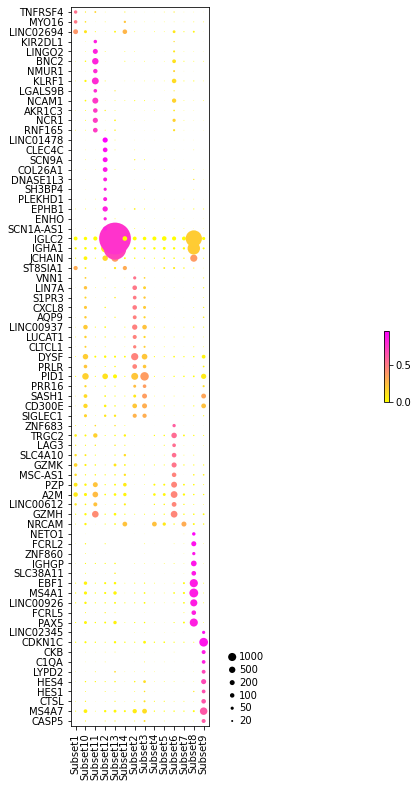

In [32]:
#Expression markers based on gene expression (by CPM) and its specificity
#Node sizes to draw legend in dot plot
node_size_cpm=[20,50,100,200,500,1000]
#Transformation from CPM to node size
node_size_map_cpm=lambda x:x/5*(x<=100)+(20+(x-100)*500/10/990)*(x>100)
#Find marker genes based on expression specificity through the option base='cpm'
deg,deg_spec,cpm,cpm_spec,expmarker,expmarker_state=compute_spec(d0,base='cpm',nmax=10,vmin=50,ncut=0.3,min_entropy=0.7)
#Draw dot plot with expression and its specificity
fig,ax=dotplot(cpm.loc[expmarker].iloc[::-1],cpm_spec.loc[expmarker].iloc[::-1],size_transform=node_size_map_cpm,sizes=np.array(node_size_cpm),cmap=cmap)


In [33]:
#Rename cell subsets
d0.rename('s',{
	'Subset1':'Treg','Subset10':'MP','Subset11':'NK.CD56h','Subset12':'DC','Subset13':'Plasma','Subset14':'Th17',
	'Subset2':'Mono.CD14.1','Subset3':'Mono.CD14.2','Subset4':'Tnaive','Subset5':'Tmem.CD4',
	'Subset6':'NK.CD56l','Subset7':'Tmem.CD8','Subset8':'B','Subset9':'Mono.CD16'})


### Replot with annotated cell types
Here we redraw these plots for validation. Expression and regulation marker analyses carry different results. The same cell type (Mono.CD14) can be clustered into separate subsets, which may show stronger differences in regulation marker than expression marker. Some other cell type (MP) might show a few regulation marker but not any expression marker.

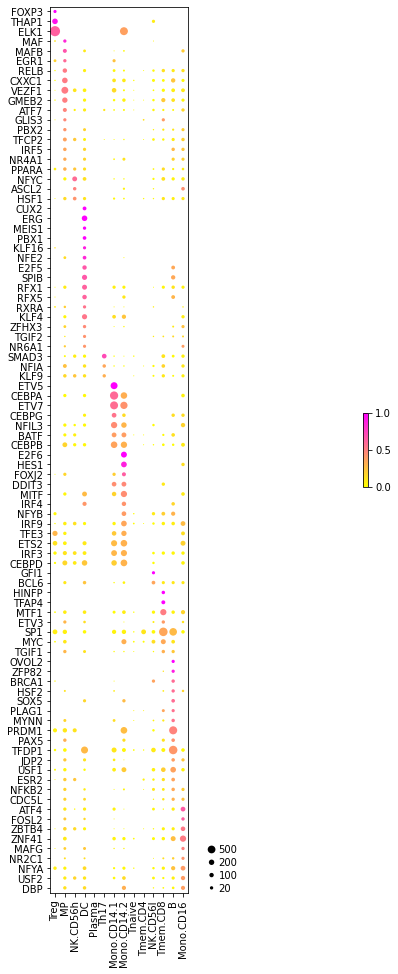

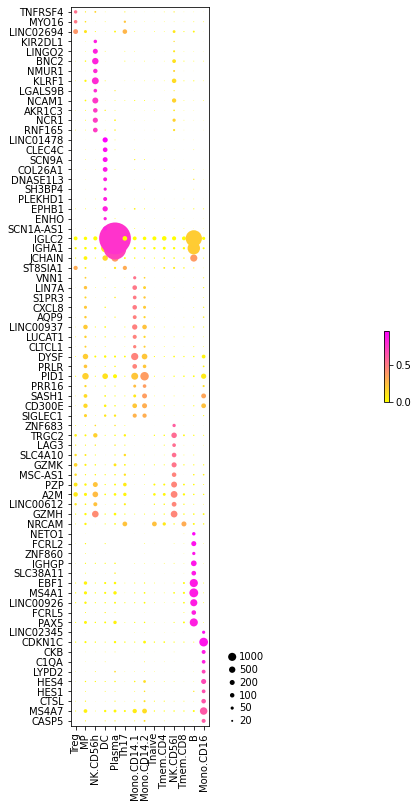

In [34]:
#Redraw of regulation marker plot
deg,deg_spec,cpm,cpm_spec,regmarker,regmarker_state=compute_spec(d0,nmax=15,vmin=10,ncut=0.3,min_entropy=0.7)
fig,ax=dotplot(deg.loc[regmarker].iloc[::-1],deg_spec.loc[regmarker].iloc[::-1],size_transform=node_size_map_deg,sizes=np.array(node_size_deg),cmap=cmap)

#Redraw of expression marker plot
deg,deg_spec,cpm,cpm_spec,expmarker,expmarker_state=compute_spec(d0,base='cpm',nmax=10,vmin=50,ncut=0.3,min_entropy=0.7)
fig,ax=dotplot(cpm.loc[expmarker].iloc[::-1],cpm_spec.loc[expmarker].iloc[::-1],size_transform=node_size_map_cpm,sizes=np.array(node_size_cpm),cmap=cmap)


### Heatmap of top target genes of select TFs in their corresponding cell types
Then we move on to investigate select regulation marker TFs. Their top target genes (by regulation strength) in the corresponding cell type may indicate their functional programs.


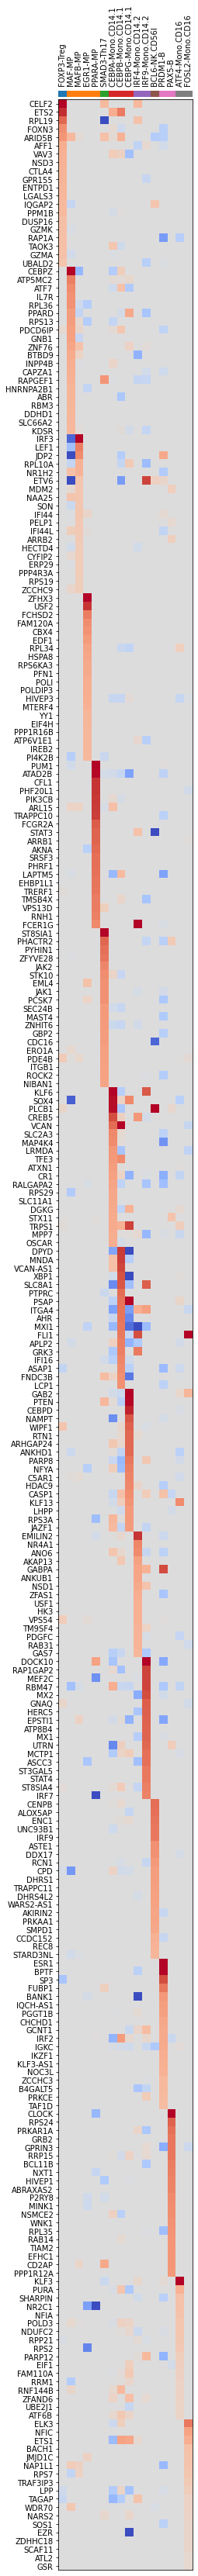

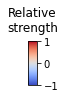

In [35]:
from dictys.plot.static import fig_heatmap_top

#TF-cell type pairs selected from the last step
tf=[('FOXP3','Treg'),
	('MAF','MP'),('MAFB','MP'),('EGR1','MP'),('PPARA','MP'),
	('SMAD3','Th17'),
	('CEBPA','Mono.CD14.1'),('CEBPB','Mono.CD14.1'),('CEBPG','Mono.CD14.1'),
	('IRF4','Mono.CD14.2'),('IRF9','Mono.CD14.2'),
	('BCL6','NK.CD56l'),
	('PRDM1','B'),('PAX5','B'),
	('ATF4','Mono.CD16'),('FOSL2','Mono.CD16')]
#Number of top targets for each TF
ntop=20
#Searching for top activated target genes only
direction=1

fig,fig_colorbar,net=fig_heatmap_top(d0,tf,ntop=ntop,direction=direction,aspect=1,gann='all')


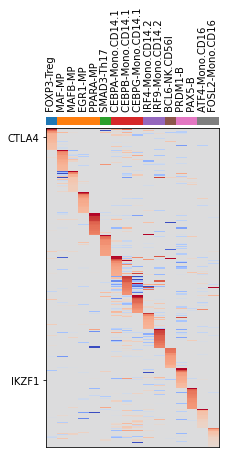

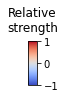

In [36]:
#Only annotating select target genes
#Target genes to annotate
gann='CTLA4,IKZF1'.split(',')
#Aspect ratio
aspect=0.1

fig,fig_colorbar,net=fig_heatmap_top(d0,tf,ntop=ntop,direction=direction,gann=gann,aspect=aspect)


### Differential regulation & differential expression analyses between two cell types
From the above global-level analyses, we zoom in for two cell types to understand the differences in their programs. Lacking a HSC population, here we compare T regs and B cells as an example.

Differential expression logFC is the log Fold Change in expression level (CPM+1). Differential regulation logFC is the log Fold Change in regulatory activity (target count+1). They each may highlight different genes for further investigations. So we plot these two axes together to understand their differences and similarities, and to inform downstream analyses.

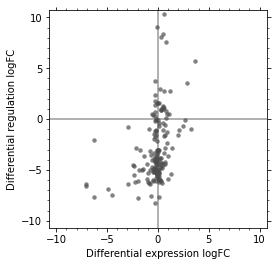

In [37]:
from dictys.plot.static import fig_diff_scatter,fig_diff_rank

#Cell type/state names to compare in (reference, alternative) format. Here it is Treg v.s. B.
states=('B','Treg')

fig=plt.figure()
ax=fig.add_subplot(111)
data=fig_diff_scatter(d0,ax,states)


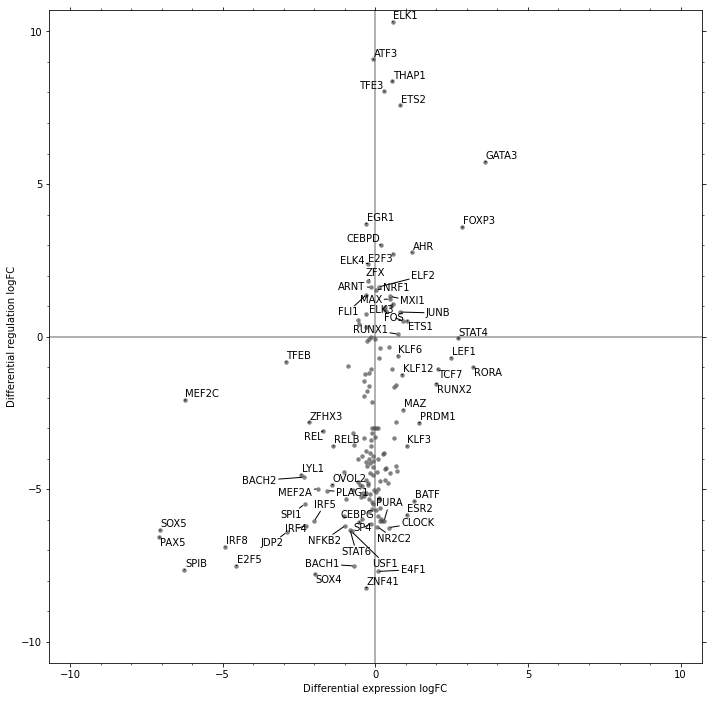

In [38]:
#Number of top genes to annotate on each side
ntop=20
#Find genes to annotate
annotate=np.partition(data.values,[ntop-1,-ntop],axis=0)
annotate=((data.values<=annotate[ntop-1])|(data.values>=annotate[-ntop])).any(axis=1)
annotate=list(data.index[annotate])
#Draw figure
fig=plt.figure(figsize=(12,12))
ax=fig.add_subplot(111)
data=fig_diff_scatter(d0,ax,states,annotate=annotate)


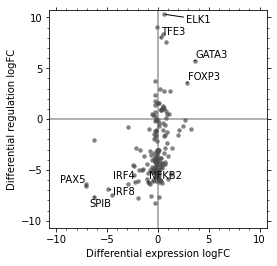

In [39]:
#Select genes to annotate
annotate='SPIB,IRF4,PAX5,IRF4,IRF8,NFKB2,FOXP3,GATA3,ELK1,TFE3'.split(',')
fig=plt.figure()
ax=fig.add_subplot(111)
data=fig_diff_scatter(d0,ax,states,annotate=annotate)


### Integrative TF ranking
We can also perform an integrative TF ranking using the mean logFC of both differential analyses. This can combine both information sources to improve this ranking on cell-type specificity.


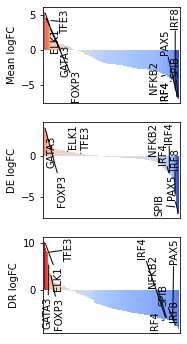

In [40]:
fig2=fig_diff_rank(data,annotate=annotate)


### Draw target gene subnetwork from a TF
We can further zoom in for a particular TF in the relevant context and look at its targets.

#### Example 1: SPIB targets in B
As before, we first draw a large figure and annotate all genes to determine which we ultimately need.

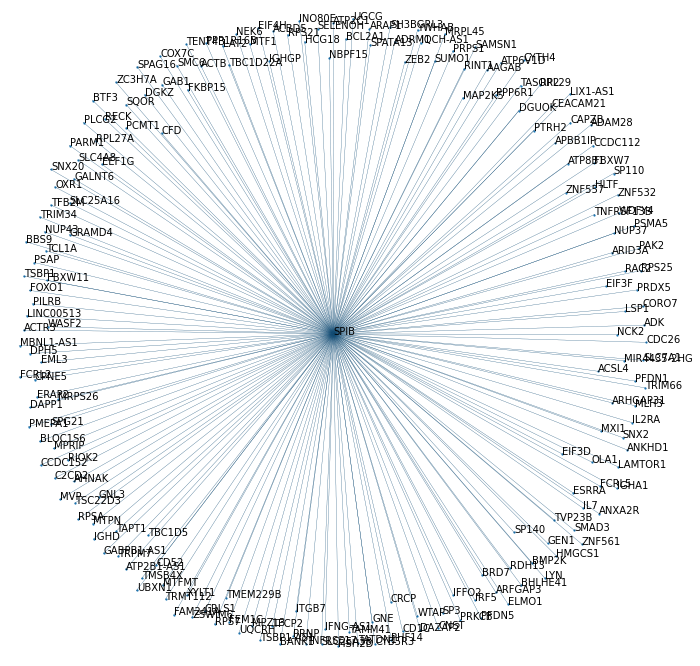

In [41]:
from dictys.plot.static import fig_subnet
fig=plt.figure(figsize=(12,12))
ax=fig.add_subplot(111)
nodes,edges=fig_subnet(d0,ax,'B',regulators=['SPIB'],annotate='all')


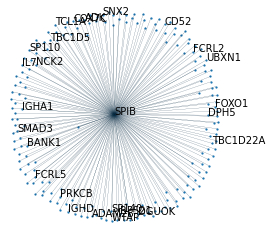

In [42]:
#Select genes to annotate
annotate='SPIB,IGHM,ZNF131,WDR48,UBXN1,ADK,GABPB1,COX7C,MED17,TCL1A,FLAD1,PAPOLA,NCK2,PHACTR1,CCR6,TBC1D22A,FCRL1,FCRL2,CD52,FCRL5,PRKCB,SP110,NCOA3,CD180,PIAS1,FCHSD2,BANK1,TBC1D5,IGHD,AIDA,SP100,ABCB4,SP140,FOXO1,MALT1,CNN2,DGUOK,ADAM28,SNX2,DPH5,IGHA1,RWDD3,SMAD3,KDM4C,WTAP,FLI1,IL7,POU2AF1,FAM30A,HLA-DRA,SP140L,RPS21'.split(',')
fig=plt.figure()
ax=fig.add_subplot(111)
nodes,edges=fig_subnet(d0,ax,'B',regulators=['SPIB'],annotate=annotate)


#### Example 2: FOXP3 in T regs

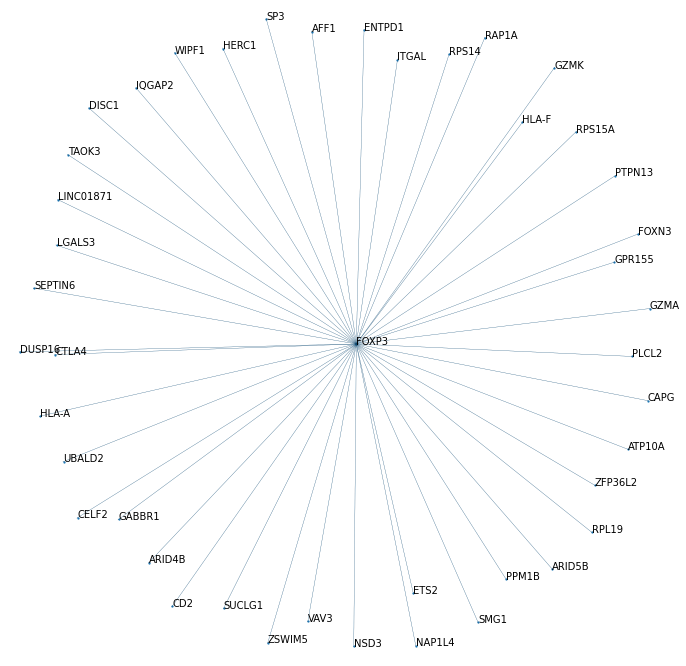

In [43]:
#FOXP3 does not have many strong regulation targets identified in T regs.
#We can make the network denser to reveal weaker regulations.
#Here we set a network sparsity cutoff that assigns 2% of all edges to be present.
sparsity=0.02
fig=plt.figure(figsize=(12,12))
ax=fig.add_subplot(111)
nodes,edges=fig_subnet(d0,ax,'Treg',regulators=['FOXP3'],sparsity=sparsity,annotate='all')


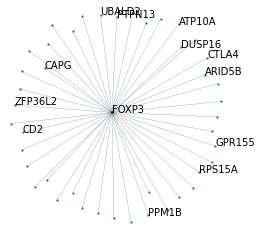

In [44]:
#Select genes to annotate
annotate='FOXP3,CTLA4,ZFP36L2,ATP10A,PPM1B,GPR155,ARID5B,UBALD2,PTPN13,RPS15A,CD2,DUSP16,CAPG'.split(',')
fig=plt.figure()
ax=fig.add_subplot(111)
nodes,edges=fig_subnet(d0,ax,'Treg',regulators=['FOXP3'],sparsity=sparsity,annotate=annotate)


### Download the inferred networks to share with collaborators and community
Others can load the networks and re-analyze/re-draw them with Dictys

In [45]:
from IPython.display import FileLink
FileLink('../output/static.h5')

./output/static.h5

### Alternatively, export the networks into tsv files

In [46]:
#Folder to export networks to
output_folder='../output/static'
#Choose which sparsities (proportion of edges present) to export network
#Use None to export continuous network
sparsities=[None,0.01]
d0.export(output_folder,sparsities=sparsities)
